# Particle transports with ocean currents

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, jit # Njit: No-Python mode, JIT (Just-In-Time compilation)
import time
from tqdm.auto import tqdm, trange # Imported to use progress bars while running code
from scipy.interpolate import RectBivariateSpline

In [ ]:
%config InlineBackend.figure_formats = ['svg'] # Makes the plots svg (visually better)

In [ ]:
# Oppgave 1a

# Constants
A = 0.1
epsilon = 0.25
w = 1.0

x_0 = np.array([1.05, 0.5])
h = np.array([2, 1, 0.5, 0.1, 0.01])

@njit
def a(t: np.ndarray, epsilon: float, w: float):
    return epsilon * np.sin(w*t)

@njit
def b(t: np.ndarray, epsilon: float, w: float):
    return 1 - 2 * epsilon * np.sin(w*t)

@njit
def f(x: float, t: np.ndarray,):
    return a(t, epsilon, w) * x**2 + b(t, epsilon, w) * x

@njit
def x_dot(x_vec, t, A, epsilon, w):
    v_x = - np.pi * A * np.sin(np.pi * f(x_vec[0],t)) * np.cos(np.pi * x_vec[1])
    v_y = np.pi * A * np.cos(np.pi * f(x_vec[0], t)) * np.sin(np.pi * x_vec[1]) * (a(t, epsilon, w) * 2 * x_vec[0] + b(t, epsilon, w))
    return np.array([v_x, v_y])

@njit
def heuns_method(t: np.ndarray, h: float, epsilon: float, w: float, A: float, x_0: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    ''''
    Heun's method for approximating position.
    Takes in a starting posiiton and returns the trajectory. 

    t: time array
    h: step length
    epsilon: parameter
    w: parameter
    A: parameter
    x_0: starting position, 1D array

    '''
    x_arr = np.zeros((len(t), 2))
    x_arr[0] = x_0
    for i in range(len(t)-1):
        k_1 = x_dot(x_arr[i], t[i], A, epsilon, w)
        k_2 = x_dot(x_arr[i] + k_1 * h, t[i] + h, A, epsilon, w)
        x_arr[i+1] = x_arr[i] + h/2 * (k_1 + k_2)
    
    return x_arr[:, 0], x_arr[:, 1]

In [ ]:
# Define a single figure for both subplots
plt.figure(figsize=(16,7))

# First subplot
plt.subplot(1, 2, 1)  # (rows, columns, subplot number)
for i in range(len(h)):
    t = np.arange(0, 50, h[i])
    x, y = heuns_method(t, h[i], epsilon, w, A, x_0)
    plt.plot(x, y, label=f"h = {h[i]}", lw=1, markersize=4)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Heun\'s Method Result with integration time 0-50 for different time steps')
plt.legend()

# Second subplot
plt.subplot(1, 2, 2)  # (rows, columns, subplot number)
for i in range(len(h)):
    t = np.arange(0, 100, h[i])
    x, y = heuns_method(t, h[i], epsilon, w, A, x_0)
    plt.plot(x, y, label=f"h = {h[i]}", lw=1, markersize=4)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Heun\'s Method Result with integration time 0-100 for different time steps')
plt.legend()

plt.show()


100


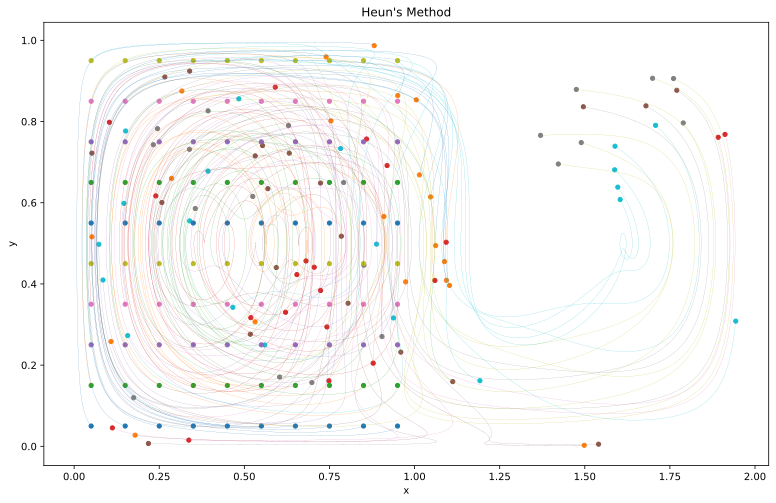

In [47]:
# Oppgave 1b

@njit
def x_dot_new(x_vec: np.ndarray, t: float, A: float, epsilon: float, w: float) -> np.ndarray:
    # Initialize the output velocity array
    v = np.zeros_like(x_vec)
    for i in range(x_vec.shape[0]):
        # Calculate v_x and v_y for each particle
        v[i, 0] = - np.pi * A * np.sin(np.pi * f(x_vec[i, 0], t)) * np.cos(np.pi * x_vec[i, 1])
        v[i, 1] = np.pi * A * np.cos(np.pi * f(x_vec[i, 0], t)) * np.sin(np.pi * x_vec[i, 1]) * (a(t, epsilon, w) * 2 * x_vec[i, 0] + b(t, epsilon, w))
    return v

def heuns_method_mod(t: np.ndarray, h: float, epsilon: float, w: float, A: float, x_0_arr: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    '''
    A modified Heun's method for approximating position. 
    Takes in an array of starting posiitons and returns an array of the trajectories. 

    t: time array
    h: step length
    epsilon: parameter
    w: parameter
    A: parameter
    x_0_arr: array of starting positions, 2D array

    '''
    x_arr = np.zeros((len(t), x_0_arr.shape[0], x_0_arr.shape[1]))
    x_arr[0] = x_0_arr
    for i in range(len(t) - 1):
        k_1 = x_dot_new(x_arr[i], t[i], A, epsilon, w)
        k_2 = x_dot_new(x_arr[i] + k_1 * h, t[i] + h, A, epsilon, w)
        x_arr[i + 1] = x_arr[i] + h / 2 * (k_1 + k_2)
    
    return x_arr

step = 0.01
t = np.arange(0, 10, step)


x_0_arr = np.zeros((100, 2))
for i in range(10):
    for j in range(10):
        x_0_arr[i*10 + j] = np.array([0.05 + i*0.1, 0.05 + j*0.1])

positions = heuns_method_mod(t, step, epsilon, w, A, x_0_arr)

In [ ]:
plt.figure(figsize=(13,8))
print(x_0_arr.shape[0])
for i in range(x_0_arr.shape[0]):
    plt.scatter(positions[0, i, 0], positions[0, i, 1], s=18)
    plt.scatter(positions[-1, i, 0], positions[-1, i, 1], s=18)
    plt.plot(positions[:, i, 0], positions[:, i, 1], lw=0.15, markersize=4, label=f'Particle {i}')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Heun\'s Method')
plt.show()

In [80]:
# Oppgave 1c
step = 0.01
t = np.arange(0, 10, step)
N_array = np.arange(10, 100000, 1000)  # Number of particles
time_array = np.zeros(len(N_array))


def position(Np: int, length: float):
    """
    Generates start positions for Np particles in a square with sidelength 'length'.
    """
    per_side = int(np.sqrt(Np))
    spacing = length / per_side
    x_0_arr = np.zeros((per_side**2, 2))
    for i in range(per_side):
        for j in range(per_side):
            x_0_arr[i * per_side + j] = np.array([(i + 0.5) * spacing, (j + 0.5) * spacing])
    return x_0_arr


for i, Np in enumerate(N_array):
    start_time = time.perf_counter()
    x_0_arr = position(Np, 1)  # Bruker en sidelengde på 1 for enkelhets skyld
    heuns_method_mod(t, step, epsilon, w, A, x_0_arr)
    end_time = time.perf_counter()
    time_array[i] = end_time - start_time

[     0  10000  20000  30000  40000  50000  60000  70000  80000  90000
 100000 110000 120000 130000 140000 150000 160000 170000 180000 190000
 200000 210000 220000 230000 240000 250000 260000 270000 280000 290000
 300000 310000 320000 330000 340000 350000 360000 370000 380000 390000
 400000 410000 420000 430000 440000 450000 460000 470000 480000 490000
 500000 510000 520000 530000 540000 550000 560000 570000 580000 590000
 600000 610000 620000 630000 640000 650000 660000 670000 680000 690000
 700000 710000 720000 730000 740000 750000 760000 770000 780000 790000
 800000 810000 820000 830000 840000 850000 860000 870000 880000 890000
 900000 910000 920000 930000 940000 950000 960000 970000 980000 990000]
(100,)


ValueError: operands could not be broadcast together with shapes (0,2) (5,) 

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(N_array, time_array)
plt.title('Kjøretid som funksjon av antall partikler', fontsize=16)
plt.xlabel('Antall partikler', fontsize=12)
plt.ylabel('Kjøretid [s]', fontsize=12)
plt.semilogx()
plt.semilogy()
plt.grid()
plt.show()

plt.show()

In [ ]:
class Interpolator():
    def __init__(self, dataset, fw = 0.03):
        # xarray dataset object
        self.dataset = dataset
        # Windage factor
        self.fw = fw
        # Extract timestamps as number of seconds after the start of the file
        # Saves a bit of bother with dealing with np.datetime objects elsewhere
        self.times = np.array([(t - d.time[0])/np.timedelta64(1, 's') for t in d.time[:]], dtype=np.float64)
        self.depth = np.array(self.dataset.h)
        
    def get_interpolators(self, X, it):
        # Add a buffer of cells around the extent of the particle cloud
        buf  = 10
        # Find extent of particle cloud in terms of indices
        imax = np.searchsorted(self.dataset.X, np.amax(X[0,:])) + buf
        imin = np.searchsorted(self.dataset.X, np.amin(X[0,:])) - buf
        jmax = np.searchsorted(self.dataset.Y, np.amax(X[1,:])) + buf
        jmin = np.searchsorted(self.dataset.Y, np.amin(X[1,:])) - buf
        # Take out subset of array, to pass to
        # interpolation object
        # Fill NaN values (land cells) with 0, otherwise
        # interpolation won't work
        u_current = self.dataset.u[it, 0, jmin:jmax, imin:imax].T.fillna(0.0)
        v_current = self.dataset.v[it, 0, jmin:jmax, imin:imax].T.fillna(0.0)
        u_wind    = self.dataset.Uwind[it, jmin:jmax, imin:imax].T.fillna(0.0)
        v_wind    = self.dataset.Vwind[it, jmin:jmax, imin:imax].T.fillna(0.0)
        # RectBivariateSpline essentially returns a function,
        # which can be called to get value at arbitrary position
        fu_current = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], u_current)
        fv_current = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], v_current)
        fu_wind    = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], u_wind)
        fv_wind    = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], v_wind)
        return fu_current, fv_current, fu_wind, fv_wind
    
    def get_time_index(self, t):
        # Get index of largest timestamp smaller than (or equal to) t
        return np.searchsorted(self.times, t, side='right') - 1
    
    def on_land(self, X):
        # Find indices for each particle
        ix_list = np.searchsorted(self.dataset.X, X[0,:])
        iy_list = np.searchsorted(self.dataset.Y, X[1,:])
        # Identify which particles are in cells with depth 5
        # (which for some reason is the smallest depth)
        return np.array([self.depth[iy,ix] == 5.0 for ix, iy in zip(ix_list, iy_list)])

    def __call__(self, X, t):
        # get index of current time in dataset
        it = self.get_time_index(t)
        # get interpolating functions,
        # covering the extent of the particle
        fu_current, fv_current, fu_wind, fv_wind = self.get_interpolators(X, it)
        # Evaluate velocity at position(x[:], y[:])
        dx = fu_current(X[0,:], X[1,:], grid = False) + self.fw*fu_wind(X[0,:], X[1,:], grid = False)
        dy = fv_current(X[0,:], X[1,:], grid = False) + self.fw*fv_wind(X[0,:], X[1,:], grid = False)
        return np.array([dx, dy])

In [ ]:
# Oppgave 2 a
# Lese inn fra fil

Np = 1000
x_mean = 790000
y_mean = 490000
std_dev = 10000
h = 3600

total_time = 24 * 3600 * 3

x = np.random.normal(x_mean, std_dev, Np)
y = np.random.normal(y_mean, std_dev, Np)